In [9]:
import os as os
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
from funktioner import paths_data_folders, read_images
import seaborn as sns
import cv2
#import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## 1. Bildbehandling 
### Läs in bilder från del 0

In [10]:
# Kontrollera om körningen sker i coolab
if os.path.abspath("") == "/content":
    !git clone https://github.com/Erik-M-Larsson/Deep_learning.git
    current_dir = os.path.abspath("Deep_learning/Lab")
else:
    current_dir = os.path.abspath("")

In [12]:
# läs in bilder
paths = paths_data_folders(current_dir)
x_train_small, x_val_small, x_test_small, y_train_small, y_val_small, y_test_small = read_images(paths[0:3])

### a)

In [13]:
dimensioner_bilder = tuple(zip(*[x.shape[0:2] for x in x_train_small]))


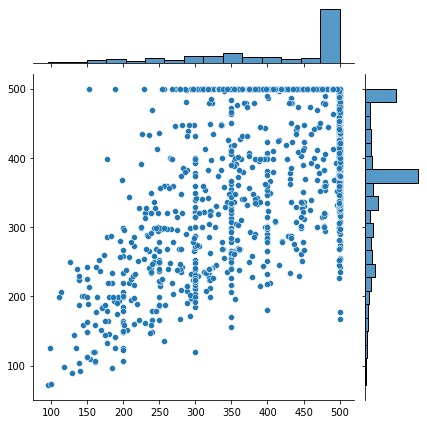

In [14]:
kinds = ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid']
sns.jointplot(x=dimensioner_bilder[1], y=dimensioner_bilder[0], kind=kinds[0]);

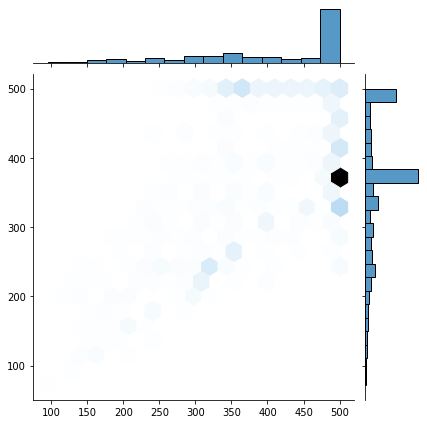

In [15]:
sns.jointplot(x=dimensioner_bilder[1], y=dimensioner_bilder[0], kind=kinds[2]);

### b)

(100, 100, 3)

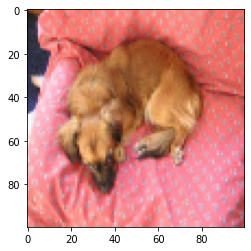

In [16]:
idx_testa =1

ratio = 1 #375/500

bredd = 100
höjd = int(ratio*bredd)

testbild = cv2.resize(x_train_small[idx_testa], (bredd, höjd),)
plt.imshow(testbild)

testbild.shape


(499, 302, 3)

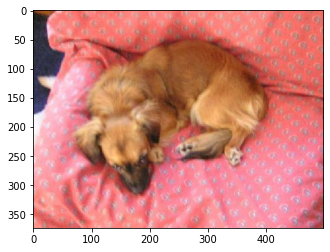

In [17]:
plt.imshow(x_train_small[idx_testa])
x_test_small[idx_testa].shape

### c)

In [18]:
def skala_om_bilder(bilder: list):
    return [cv2.resize(bild, (bredd, höjd),) for bild in bilder]

In [19]:
x_train_resized_small =  np.array(skala_om_bilder(x_train_small), dtype=np.float32)/255
x_val_resized_small =  np.array(skala_om_bilder(x_val_small), dtype=np.float32)/255
x_test_resized_small =  np.array(skala_om_bilder(x_test_small), dtype=np.float32)/255


In [20]:
x_train_resized_small.shape


(1600, 100, 100, 3)

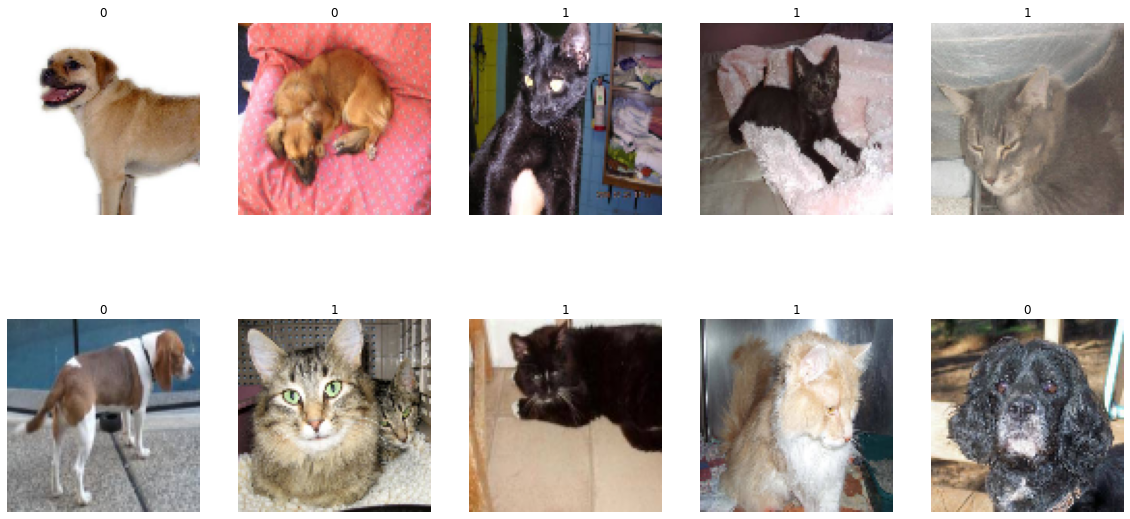

In [21]:
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(20,10)

for x, y, ax in zip(x_train_resized_small, y_train_small, axes.flatten()):

    ax.imshow(x)
    ax.set_title(f"{y}")    
    ax.axis("off")

### d)

In [22]:
augmented_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
    
)

train_test_image_generator = ImageDataGenerator()



In [23]:
bildförvrängare = augmented_image_generator.flow(x_train_resized_small, y_train_small, batch_size = len(x_train_resized_small))

bildförvrängare[0][0].shape


(1600, 100, 100, 3)

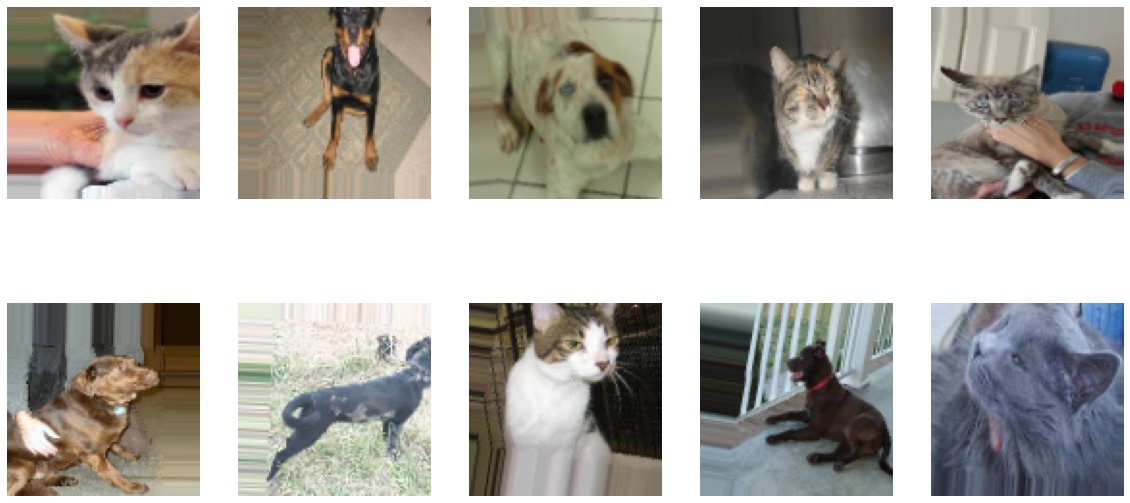

In [24]:
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(20,10)

for x, y, ax in zip(bildförvrängare[0][0], y_train_small, axes.flatten()):

    ax.imshow(x)
    #ax.set_title(f"{y}")    
    ax.axis("off")

In [25]:
# Utöka antalet bilder
x_train_augmented_small = x_train_resized_small.copy() 
y_train_augmented_small = y_train_small.copy()

faktor_fler_bilder = 5

for bilder,_ in zip(bildförvrängare, range(faktor_fler_bilder-1)):

    x_train_augmented_small = np.concatenate((x_train_augmented_small,  bilder[0]))
    y_train_augmented_small = np.concatenate((y_train_augmented_small,  bilder[1]))
    
    
x_train_augmented_small.shape, y_train_augmented_small.shape


((8000, 100, 100, 3), (8000,))

In [26]:
# Randomisera ordningen
indices = np.arange(x_train_augmented_small.shape[0])
np.random.shuffle(indices)

x_train_augmented_small = x_train_augmented_small[indices]
y_train_augmented_small = y_train_augmented_small[indices]

x_train_augmented_small.shape, y_train_augmented_small.shape

((8000, 100, 100, 3), (8000,))

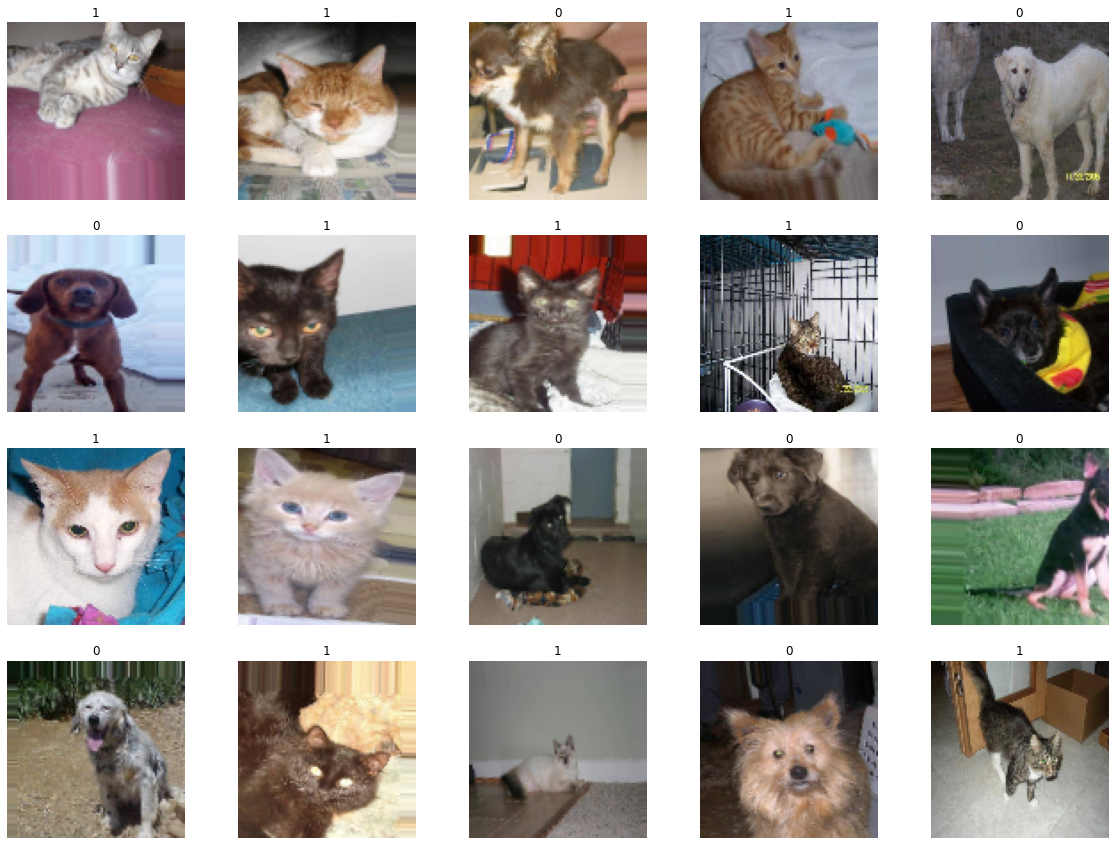

In [27]:
# Rita ut exempelbilder med etikett
fig, axes = plt.subplots(4, 5)
fig.set_size_inches(20,15)

for x, y, ax in zip(x_train_augmented_small, y_train_augmented_small, axes.flatten()):

    ax.imshow(x)
    ax.set_title(f"{y}")    
    ax.axis("off")

## 2. Träna modeller
### a)

In [28]:

def CNN_model( input_shape, learning_rate=0.001, drop_rate=0.3, kernels=[32, 64, 128, 128]):
    adam = Adam(learning_rate=learning_rate)
    model = Sequential(name="CNN_model")


    for number_kernel in kernels:
            conv_layer = Conv2D(
                number_kernel,
                kernel_size=(3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                input_shape=input_shape,
            )

            model.add(conv_layer)
            
            model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
            loss="binary_crossentropy", optimizer=adam, metrics=["acc"]
        )
    return model


In [29]:
def apa(x_train, x_val, y_train, y_val, epochs= 100, batch_size = 32, patience = 5, **kwargs):
    model = CNN_model(input_shape=x_train.shape[1:], **kwargs) 

    steps_per_epoch = int(len(x_train)/batch_size)
    validation_steps = int(len(x_val)/batch_size)

    early_stopper = EarlyStopping(
        monitor="val_acc", mode="max", patience=patience, restore_best_weights=True
    )

    train_generator = train_test_image_generator.flow(
        x_train, y_train, batch_size=batch_size
    )

    val_generator = train_test_image_generator.flow(
        x_val, y_val, batch_size=batch_size
    )

    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[early_stopper],
        validation_data=val_generator,
        validation_steps=validation_steps,
    )

    metrics = pd.DataFrame(model.history.history)
    return metrics

In [30]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)



In [31]:
# Utan augmentering
metrics = apa(x_train_resized_small, x_val_resized_small, y_train_small, y_val_small)
plot_metrics(metrics)

Epoch 1/100
41/50 [=======================>......] - ETA: 4s - loss: 0.7966 - acc: 0.5290

: 

: 

In [ ]:
# Med augmentering
metrics = apa(x_train_augmented_small, x_val_resized_small, y_train_augmented_small, y_val_small)
plot_metrics(metrics)

Epoch 1/100
  5/250 [..............................] - ETA: 2:09 - loss: 1.4726 - acc: 0.4938

KeyboardInterrupt: 

In [ ]:
# Testa olika learning rate och drop rate

learning_rates =  [0.01, 0.005, 0.001, 0.0005, 0.0001]
drop_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

metrics_grid =[]
for i, lr in enumerate(learning_rates):
    metrics_row = []
    for j, dr in enumerate(drop_rates):
        metrics = apa(x_train_resized_small, x_val_resized_small, y_train_small, y_val_small, learning_rate=lr, drop_rate=dr, patience=7)
        metrics_row.append(metrics)
        
    metrics_grid.append(metrics_row)

Epoch 1/100
 3/50 [>.............................] - ETA: 24s - loss: 60.5583 - acc: 0.4479

KeyboardInterrupt: 

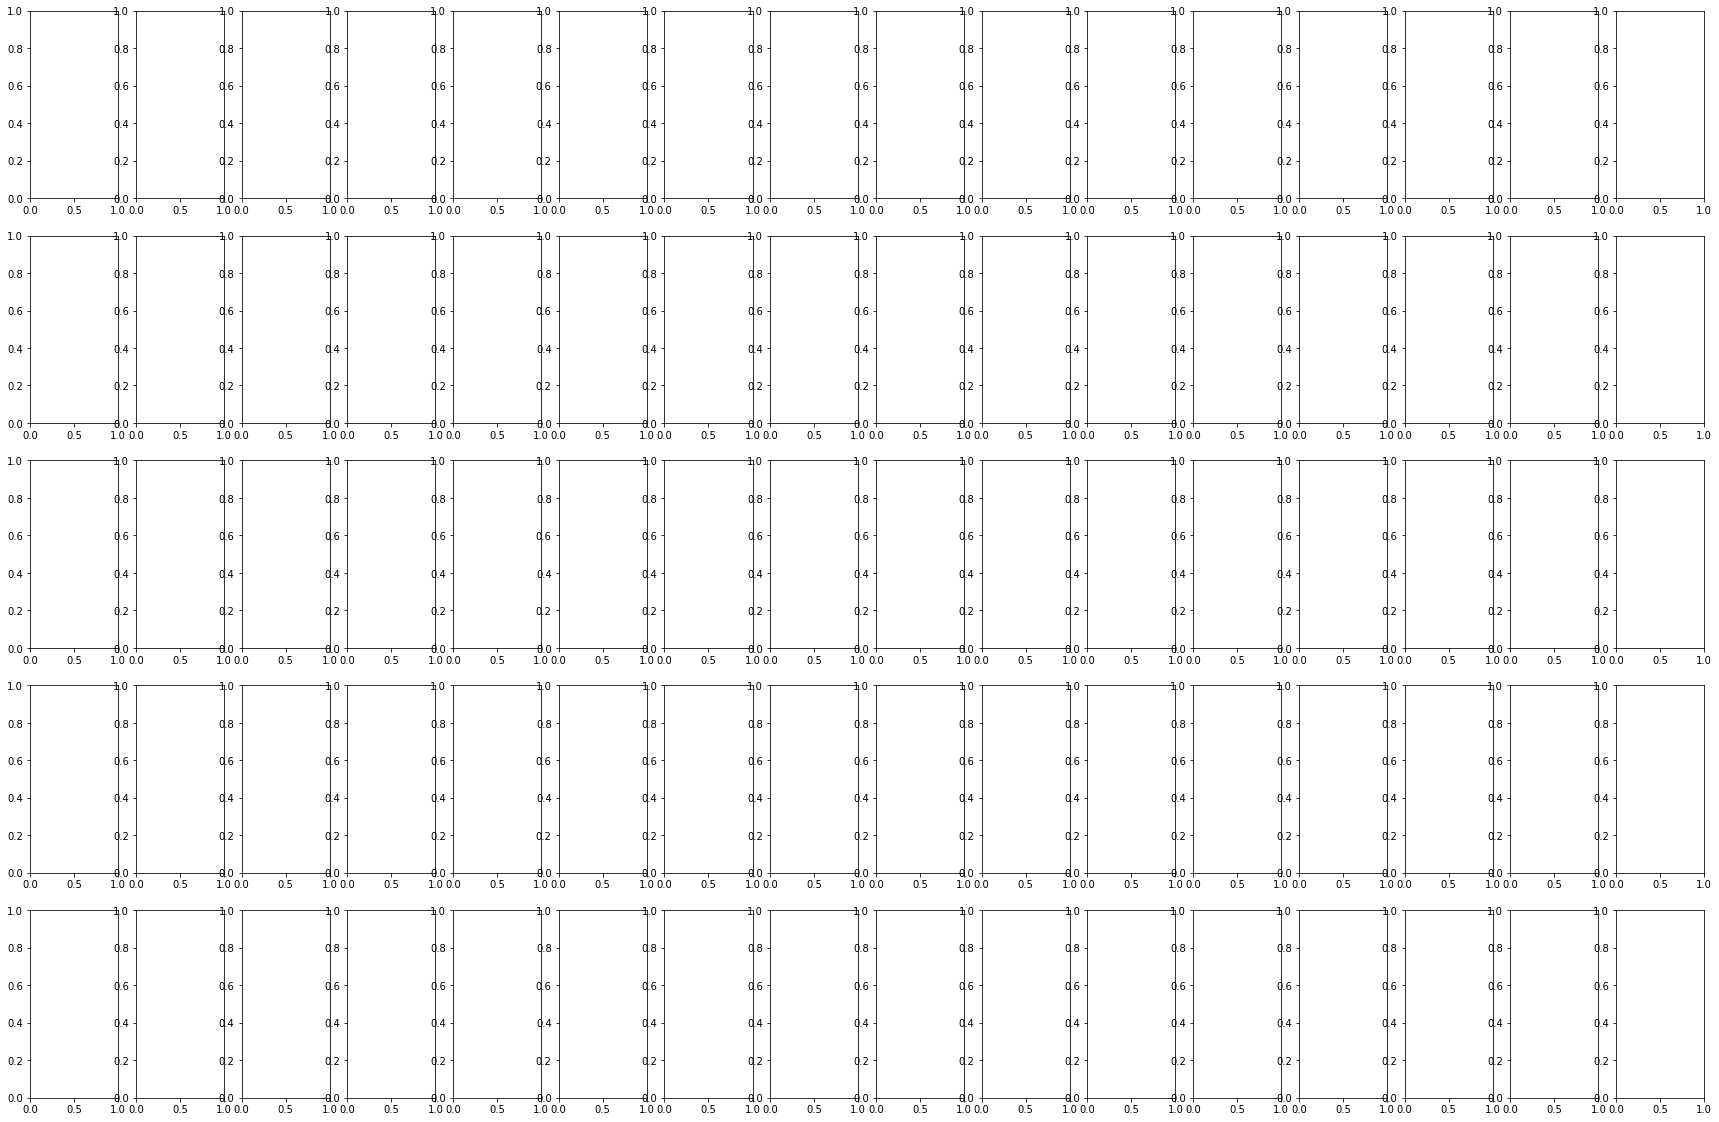

In [ ]:
#  rita ut resultat

_, axes = plt.subplots(len(learning_rates), 2*len(drop_rates), figsize = (30, 20))

for i, metrics_row in enumerate(metrics_grid):
        for j, metrics in enumerate(metrics_row):
                
                metrics[["loss", "val_loss"]].plot(ax = axes[i, 2*j], title = f"Loss lr={learning_rates[i]} dr={drop_rates[j]}", grid = True)
                metrics[["acc", "val_acc"]].plot(ax = axes[i, 2*j+1], title = f"Accuracy lr={learning_rates[i]} dr={drop_rates[j]}", grid = True)

plt.show()
        

### b)